<a href="https://colab.research.google.com/github/marcelodepaoli/20_Natural_Language_Processing/blob/main/01_NLP_(Natural_Language_Processing)_com_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Discutiremos uma visão geral dos fundamentos do Processamento de Linguagem Natural, que consiste em combinar técnicas de aprendizado de máquina com texto, utilizando matemática/estatística para obter esse texto em um formato que os algoritmos de aprendizado de máquina possam entender.

    
**Requisitos: Você precisará ter o NLTK instalado, juntamente com o download do corpus para palavras irrelevantes (stopwords)**

In [5]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Obtenha os dados

Usaremos um conjunto de dados do [UCI datasets](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection). Este conjunto de dados já está localizado na pasta desta seção.

O arquivo que estamos usando contém uma coleção de mais de 5 mil mensagens telefônicas SMS. Você pode conferir o arquivo **readme** para mais informações.

Vamos em frente e usar rstrip() mais uma compreensão de lista para obter uma lista de todas as linhas de mensagens de texto:

In [ ]:
# Esse trecho do código é obrigatório para quem estiver fazendo tudo pelo colab
# Caso você esteja utilizando o jupyter pode comentar/apagar
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir("drive/My Drive/Colab Notebooks/IA/20_Natural_Language_Processing")
os.listdir()

In [7]:
messages = [line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')]
print(len(messages))

5574


Uma coleção de textos também é chamada de "corpus". Vamos imprimir as dez primeiras mensagens e numerá-las usando **enumerate**:

In [8]:
for message_no, message in enumerate(messages[:20]):
  print(message_no, message)

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1 ham	Ok lar... Joking wif u oni...
2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3 ham	U dun say so early hor... U c already then say...
4 ham	Nah I don't think he goes to usf, he lives around here though
5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
6 ham	Even my brother is not like to speak with me. They treat me like aids patent.
7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8 spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 

Devido ao espaçamento, podemos dizer que este é um [TSV](http://en.wikipedia.org/wiki/Tab-separated_values) ("tab separated values") arquivo, onde a primeira coluna é um rótulo dizendo se a mensagem fornecida é uma mensagem normal (comumente conhecida como "ham") ou "spam". A segunda coluna é a própria mensagem. (Observe que nossos números não fazem parte do arquivo, eles são apenas da chamada **enumerate**).

Usando esses exemplos rotulados de ham e spam, **treinaremos um modelo de aprendizado de máquina para aprender a discriminar entre ham/spam automaticamente**. Então, com um modelo treinado, poderemos **classificar mensagens arbitrárias sem rótulo** como ham ou spam.

Em vez de analisar o TSV manualmente usando Python, podemos aproveitar os pandas.

In [9]:
import pandas as pd

Usaremos read_csv com o argumento sep, também podemos especificar os nomes das colunas desejadas passando uma lista de nomes.

In [10]:
messages = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t', names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Análise exploratória de dados

Vamos conferir algumas das estatísticas com gráficos e os métodos embutidos no pandas

In [11]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Vamos usar **groupby** para usar descrever por rótulo (label), dessa forma podemos começar a pensar nas características que separam ham e spam

In [12]:
messages.groupby("label").describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

À medida que continuamos nossa análise, queremos começar a pensar nas características que usaremos. Isso está de acordo com a ideia geral de [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering). Quanto melhor seu conhecimento de domínio sobre os dados, melhor sua capacidade de projetar mais carcterísticas a partir deles.

Fazendo uma nova coluna para detectar o quão longos os textos das mensagens são:

In [13]:
messages["length"] = messages["message"].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Visualização de dados

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: ylabel='Frequency'>

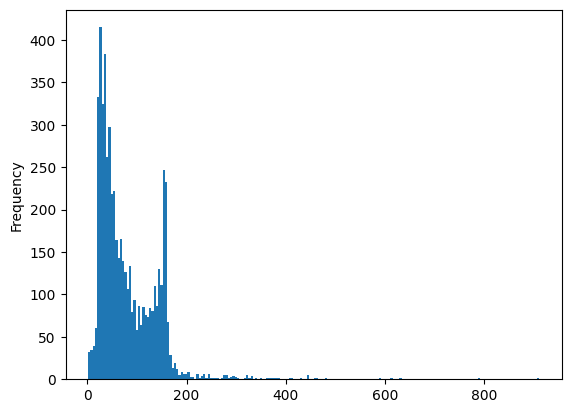

In [18]:
messages["length"].plot(bins=200, kind="hist")

Parece que o comprimento do texto pode ser uma boa característica para se pensar! 

Vamos tentar explicar por que o eixo x vai até 1000, isso deve significar que há uma mensagem muito longa!

In [19]:
messages.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

910 caracteres! vamos encontrar esta mensagem:

In [24]:
messages[messages["length"] == 910]["message"].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

Parece que temos algum tipo de Romeu mandando mensagens!

Mas vamos nos concentrar novamente na ideia de tentar descobrir se o comprimento da mensagem é uma característica distintiva entre ham e spam:

array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

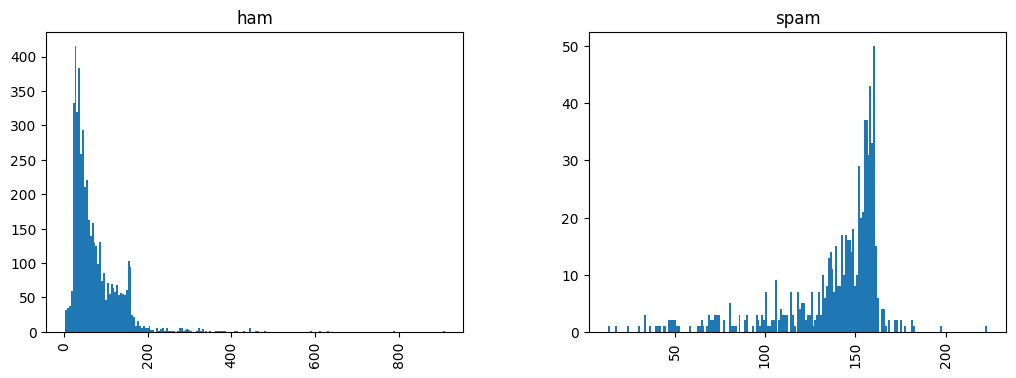

In [25]:
messages.hist(column="length", by="label", bins=200, figsize=(12,4))

Por meio de um EDA básico, conseguimos descobrir uma tendência de que as mensagens de spam tendem a ter mais caracteres. (Desculpe Romeu!)

Agora vamos começar a processar os dados para que possamos usá-los com o SciKit Learn!

## Pré-processamento de texto

Nosso principal problema com nossos dados é que estão todos em formato de texto (strings). Os algoritmos de classificação que aprendemos até agora precisarão de algum tipo de vetor de recursos numéricos para realizar a tarefa de classificação. Na verdade, existem muitos métodos para converter um corpus em um formato vetorial. O mais simples é a abordagem de [bag-of-words](http://en.wikipedia.org/wiki/Bag-of-words_model), onde cada palavra única em um texto será representada por um número.

Vamos converter as mensagens brutas (sequência de caracteres) em vetores (sequência de números).

Primeiro, vamos escrever uma função que dividirá uma mensagem em suas palavras individuais e retornará uma lista. Também removeremos palavras muito comuns ('the', 'a', etc.). Para isso, vamos aproveitar a biblioteca **NLTK**. Ela é praticamente a biblioteca padrão em Python para processamento de texto e possui muitos recursos úteis. Usaremos apenas alguns dos básicos aqui.

Vamos criar uma função que irá processar a string na coluna de mensagem, então podemos usar **apply()** do pandas para processar todo o texto no DataFrame.

Primeiro removendo a pontuação. Podemos apenas aproveitar a biblioteca **string** incorporada do Python para obter uma lista rápida de todas as pontuações possíveis:


In [26]:
import string

In [27]:
mess = "Sample message! Notice: it has punctuation."

In [28]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [29]:
nopunc = [char for char in mess if char not in string.punctuation]

In [30]:
print(nopunc)

['S', 'a', 'm', 'p', 'l', 'e', ' ', 'm', 'e', 's', 's', 'a', 'g', 'e', ' ', 'N', 'o', 't', 'i', 'c', 'e', ' ', 'i', 't', ' ', 'h', 'a', 's', ' ', 'p', 'u', 'n', 'c', 't', 'u', 'a', 't', 'i', 'o', 'n']


In [31]:
nopunc = ''.join(nopunc)

In [32]:
print(nopunc)

Sample message Notice it has punctuation


Agora vamos ver como remover palavras irrelevantes. Podemos importar uma lista de palavras irrelevantes em inglês do NLTK (verifique a documentação para mais idiomas e informações).

In [33]:
from nltk.corpus import stopwords

In [34]:
stopwords.words('english')[0:20]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

In [35]:
nopunc.split()

['Sample', 'message', 'Notice', 'it', 'has', 'punctuation']

In [36]:
clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords.words("english")]

In [37]:
print(clean_mess)

['Sample', 'message', 'Notice', 'punctuation']


Vamos colocar os dois juntos em uma função para aplicá-lo ao nosso DataFrame mais tarde:

In [38]:
def text_process(mess):
  """
  Recebe uma sequência de texto e, em seguida, executa o seguinte:
  1. Remove toda a pontução
  2. Remove todas as stopwords
  3. Retorna uma lista do texto limpo
  """
  nopunc = [char for char in mess if char not in string.punctuation]
  nopunc = ''.join(nopunc)
  return [word for word in nopunc.split() if word.lower() not in stopwords.words("english")]

Aqui está o DataFrame original novamente:

In [39]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Agora vamos "tokenizar" essas mensagens. Tokenização é apenas o termo usado para descrever o processo de conversão de strings de texto normais em uma lista de tokens (palavras que realmente queremos).

Vamos ver um exemplo de saída na coluna:

**Observação:**
Podemos receber alguns avisos ou erros para símbolos que não consideramos ou que não estavam em Unicode (como um símbolo de libra esterlina)

In [40]:
#Verificando se está funcionando
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

### Continuação da normalização

Há muitas maneiras de continuar normalizando este texto. Tal como [Stemming](https://en.wikipedia.org/wiki/Stemming) ou distinguir por [parte do discurso](http://www.nltk.org/book/ch05.html).

O NLTK possui muitas ferramentas integradas e ótima documentação sobre muitos desses métodos. Às vezes, eles não funcionam bem para mensagens de texto devido à maneira como muitas pessoas tendem a usar abreviações ou taquigrafias, por exemplo:
    
    'Nah dawg, IDK! Wut time u headin to da club?'
    
versus

    'No dog, I don't know! What time are you heading to the club?'
    
Alguns métodos de normalização de texto terão problemas com esse tipo de abreviação e, portanto, deixarei você explorar esses métodos mais avançados através do [NLTK book online](http://www.nltk.org/book/).

Por enquanto vamos nos concentrar apenas em usar o que temos para converter nossa lista de palavras em um vetor real que o SciKit-Learn pode usar.

## Vetorização

Agora, temos as mensagens como listas de tokens (também conhecidas como [lemmas](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)) e precisamos converter cada uma dessas mensagens em um vetor com o qual os modelos de algoritmo do SciKit Learn possam trabalhar.

Faremos isso em três etapas usando o modelo bag-of-words:

1. Contando quantas vezes uma palavra ocorre em cada mensagem (conhecida como frequência de termo)

2. Pesar as contagens, para que os tokens frequentes tenham um peso menor (frequência inversa do documento)

3. Normalizar os vetores para comprimento unitário, para abstrair do comprimento do texto original (L2 norm)

Vamos começar o primeiro passo:

Cada vetor terá tantas dimensões quantas forem as palavras únicas no corpus SMS. Primeiro, usaremos o **CountVectorizer** do SciKit Learn. Este modelo converterá uma coleção de documentos de texto em uma matriz de contagem de tokens.

Podemos imaginar isso como uma matriz bidimensional. Onde a dimensão 1 é todo o vocabulário (1 linha por palavra) e a outra dimensão são os documentos reais, neste caso uma coluna por mensagem de texto.

Por exemplo:

<table border = “1“>
<tr>
<th></th> <th>Message 1</th> <th>Message 2</th> <th>...</th> <th>Message N</th> 
</tr>
<tr>
<td><b>Word 1 Count</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word 2 Count</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word N Count</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>


Como há tantas mensagens, podemos esperar muitas contagens com zero para a presença de uma dada palavra em um determinado documento. Por causa disso, o SciKit Learn produzirá uma [Sparse Matrix](https://en.wikipedia.org/wiki/Sparse_matrix).

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

Existem muitos argumentos e parâmetros que podem ser passados ​​para o CountVectorizer. Neste caso vamos apenas especificar que o **analyzer** seja a nossa função previamente definida:

In [42]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages["message"])

Vamos pegar uma mensagem de texto e obter sua contagem de palavras como um vetor, usando nosso novo `bow_transformer`:

In [43]:
message4 = messages["message"][3]
print(message4)

U dun say so early hor... U c already then say...


Agora vamos ver sua representação vetorial:

In [44]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2
(1, 11425)


Isso significa que há sete palavras únicas na mensagem número 4 (depois de remover as palavras de parada comuns). Dois deles aparecem duas vezes, o resto apenas uma vez. Vamos verificar e confirmar quais aparecem duas vezes:

In [45]:
print(bow_transformer.get_feature_names_out()[4068])
print(bow_transformer.get_feature_names_out()[9554])

U
say


Agora podemos usar **.transform** em nosso objeto transformado Bag-of-Words (bow) e transformar todo o DataFrame de mensagens:

In [46]:
messages_bow = bow_transformer.transform(messages["message"])

In [47]:
print("Shape of Sparce Matrix: ", messages_bow.shape)
print("Amount of Non-Zero Occurrences: ", messages_bow.nnz)

Shape of Sparce Matrix:  (5572, 11425)
Amount of Non-Zero Occurrences:  50548


In [49]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print("Sparsity: {}".format(sparsity))

Sparsity: 0.07940295412668218


Após a contagem, a ponderação e a normalização dos termos podem ser feitas com [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), utilizando scikit-learn `TfidfTransformer`.

### O que é TF-IDF?
TF-IDF significa *term frequency-inverse document frequency*, e o tf-idf weight é um peso frequentemente usado na recuperação de informações e mineração de texto. Esse peso é uma medida estatística usada para avaliar a importância de uma palavra para um documento em uma coleção ou corpus. A importância aumenta proporcionalmente ao número de vezes que uma palavra aparece no documento, mas é compensada pela frequência da palavra no corpus. Variações do esquema de ponderação tf-idf são frequentemente usadas pelos mecanismos de pesquisa como uma ferramenta central na pontuação e classificação da relevância de um documento dada a consulta do usuário.

Uma das funções de classificação mais simples é calculada somando o tf-idf para cada termo de consulta; muitas funções de classificação mais sofisticadas são variantes desse modelo simples.

Normalmente, o tf-idf weight é composto por dois termos: o primeiro calcula a normalized Term Frequency (TF), aka. o número de vezes que uma palavra aparece em um documento, dividido pelo número total de palavras naquele documento; o segundo termo é a Frequência Inversa de Documentos (IDF), calculada como o logaritmo do número de documentos no corpus dividido pelo número de documentos onde o termo específico aparece.

**TF: Term Frequency**, mede a frequência com que um termo ocorre em um documento. Como cada documento é diferente em tamanho, é possível que um termo apareça muito mais vezes em documentos longos do que em documentos mais curtos. Assim, a frequência do termo é frequentemente dividida pelo comprimento do documento (também conhecido como o número total de termos no documento) como forma de normalização:

*TF(t) = (Número de vezes que o termo t aparece em um documento) / (Número total de termos no documento).*

**IDF: Inverse Document Frequency**, mede a importância de um termo. Ao calcular TF, todos os termos são considerados igualmente importantes. No entanto, sabe-se que certos termos, como “é”, “de” e “isso”, podem aparecer muitas vezes, mas têm pouca importância. Assim, precisamos pesar os termos frequentes enquanto escalamos os raros, calculando o seguinte:

*IDF(t) = log(Número total de documentos / Número de documentos com termo t nele).*

Veja abaixo um exemplo simples.

**Exemplo:**

Considere um documento contendo 100 palavras em que a palavra gato aparece 3 vezes.

O termo frequência (ou seja, tf) para gato é então (3/100) = 0,03. Agora, suponha que temos 10 milhões de documentos e a palavra gato aparece em mil deles. Então, a frequência inversa do documento (ou seja, idf) é calculada como log(10.000.000 / 1.000) = 4. Assim, o peso Tf-idf é o produto dessas quantidades: 0,03 * 4 = 0,12.

In [50]:
from sklearn.feature_extraction.text import TfidfTransformer

In [51]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 9554)	0.5385626262927564
  (0, 7186)	0.4389365653379857
  (0, 6222)	0.3187216892949149
  (0, 6204)	0.29953799723697416
  (0, 5261)	0.29729957405868723
  (0, 4629)	0.26619801906087187
  (0, 4068)	0.40832589933384067


Vamos em frente e verificar qual é o IDF (inverse document frequency) 
da palavra `"u"` e de palavra `"university"`?

In [52]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

3.2800524267409408
8.527076498901426


Para transformar todo o corpus bag-of-words em corpus TF-IDF de uma só vez:

In [53]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 11425)


Há muitas maneiras de pré-processar e vetorizar os dados. Essas etapas envolvem feature engineering e construção de um "pipeline". Convido você a verificar a documentação do SciKit Learn sobre como lidar com dados de texto, bem como a ampla coleção de artigos e livros disponíveis sobre o tópico geral de NLP.

## Treinando um modelo

Com as mensagens representadas como vetores, podemos finalmente treinar nosso classificador de spam/ham. Agora podemos usar praticamente qualquer tipo de algoritmo de classificação. Por [uma variedade de razões](http://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn-note07-2up.pdf), o algoritmo classificador Naive Bayes é uma boa escolha.


Estaremos usando o scikit-learn aqui, escolhendo o [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) classificador para começar:

In [54]:
from sklearn.naive_bayes import MultinomialNB

In [55]:
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages["label"])

Vamos tentar classificar nossa única mensagem aleatória e verificar como fazemos:

In [56]:
print("predicted: ", spam_detect_model.predict(tfidf4)[0])
print("expected: ", messages.label[3])

predicted:  ham
expected:  ham


Fantástico! Desenvolvemos um modelo que pode tentar prever a classificação de spam versus ham!

## Avaliação do modelo

Agora queremos determinar o desempenho geral do nosso modelo em todo o conjunto de dados. Vamos começar obtendo todas as previsões:

In [57]:
all_predictions = spam_detect_model.predict(messages_tfidf)
print(all_predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


Podemos usar o relatório de classificação integrado do SciKit Learn, que retorna [precision, recall,](https://en.wikipedia.org/wiki/Precision_and_recall) [f1-score](https://en.wikipedia.org/wiki/F1_score), e uma coluna para suporte (ou seja, quantos casos deram suporte a essa classificação). Confira os links para informações mais detalhadas sobre cada uma dessas métricas e a figura abaixo:

In [58]:
from sklearn.metrics import classification_report

In [59]:
print(classification_report(messages["label"], all_predictions))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4825
        spam       1.00      0.85      0.92       747

    accuracy                           0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572



Existem algumas métricas possíveis para avaliar o desempenho do modelo. Qual é o mais importante depende da tarefa e dos efeitos de negócios das decisões baseadas no modelo. Por exemplo, o custo de prever erroneamente "spam" como "ham" é provavelmente muito menor do que prever erroneamente "ham" como "spam".

Na "avaliação" acima, avaliamos a precisão nos mesmos dados que usamos para o treinamento. **Você nunca deve avaliar no mesmo conjunto de dados em que treina!**

Tal avaliação não nos diz nada sobre o verdadeiro poder preditivo do nosso modelo. Se simplesmente lembrássemos de cada exemplo durante o treinamento, a precisão nos dados de treinamento seria trivialmente 100%, mesmo que não pudéssemos classificar nenhuma mensagem nova.

Uma maneira adequada é dividir os dados em um conjunto de treinamento/teste, em que o modelo só vê os **dados de treinamento** durante o ajuste do modelo e o ajuste dos parâmetros. Os **dados de teste** nunca são usados ​​de forma alguma. Esta é, então, nossa avaliação final sobre os dados de teste é representativa do verdadeiro desempenho preditivo.

## Divisão de teste de treino

In [60]:
from sklearn.model_selection import train_test_split

In [68]:
msg_train, msg_test, label_train, label_test = train_test_split(messages["message"], messages["label"], test_size=0.2)

In [69]:
print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572


O tamanho do teste é 20% de todo o conjunto de dados (1.115 mensagens de um total de 5.572), e o treinamento é o restante (4.457 de 5.572). Observe que a divisão padrão teria sido 30/70.

## Criando um pipeline de dados

Vamos executar nosso modelo novamente e, em seguida, prever fora do conjunto de teste. Usaremos o SciKit Learn [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) para armazenar um pipeline de fluxo de trabalho. Isso nos permitirá configurar todas as transformações que faremos nos dados para uso futuro. Vamos ver um exemplo de como funciona:

In [63]:
from sklearn.pipeline import Pipeline

In [70]:
pipeline = Pipeline([
    ("bow", CountVectorizer(analyzer=text_process)),
    ("tfidf", TfidfTransformer()),
    ("classifier", MultinomialNB())
                     
])

Agora podemos passar diretamente os dados de texto da mensagem e o pipeline fará nosso pré-processamento para nós! Podemos tratá-lo como uma API de modelo/estimador:

In [71]:
pipeline.fit(msg_train, label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7fe53e633f70>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [72]:
predictions = pipeline.predict(msg_test)

In [73]:
print(classification_report(predictions, label_test))

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98      1014
        spam       0.71      1.00      0.83       101

    accuracy                           0.96      1115
   macro avg       0.86      0.98      0.91      1115
weighted avg       0.97      0.96      0.97      1115



Agora temos um relatório de classificação para nosso modelo em um verdadeiro conjunto de testes!

## Mais recursos

Confira os links abaixo para obter mais informações sobre o Processamento de Linguagem Natural:

[NLTK Book Online](http://www.nltk.org/book/)

[Kaggle Walkthrough](https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words)

[SciKit Learn's Tutorial](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)